In [215]:
import numpy as np
import numpy.random as npr
import json
from io import open
import time
import os.path

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set_color_codes()
plt.rcParams['figure.figsize'] = (6,4)

import tensorflow as tf

## Import the data and convert it to the NER task format

In [2]:
data = json.loads(open('../data/ace_05_yaat.json', 'r').read())

In [150]:
from collections import Counter
import numpy as np
import numpy.random as npr

class Vocab():
    """ A convenience vocabulary wrapper 
    
    TODO: Add in sampling table functionality
    """
    def __init__(self, 
                 tokens=None, 
                 min_count=5,
                 pad_token='<PAD>', 
                 unk_token='<UNK>'):
        self.min_count=min_count
        self.pad_token = pad_token
        self.unk_token = unk_token
        
        self.use(tokens)
#         self.make_sampling_table()

    @property
    def n(self):
        """ The total number of tokens seen by the vocabulary.
        
        This **does not** include tokens which have not been seen `min_count` times
        """
        return self._n

    @property
    def v(self):
        """ The total number of unique tokens in the vocabulary.
        
        This **does not** include tokens which have not been seen `min_count` times
        """
        return self._v

    @property
    def pad(self):
        """ Return the PAD token """
        return self.pad_token

    @property
    def ipad(self):
        """ Return the index of the PAD token """
        return self.idx(self.pad_token)
    
    @property
    def unk(self):
        """ Return the UNK token """
        return self.unk_token

    @property
    def iunk(self):
        """ Return the index of the UNK token """
        return self.idx(self.unk_token)

    def idx(self, token):
        """ Return the index of a token or the index of UNK if not in vocab.
        
        Additionally this will return UNK if the token is in the vocab 
        but has yet to be seen `min_count` times
        """
        if token == self.pad_token:
            return self._vocab2idx[token]
        elif token in self.vocabset:
            if self.count_index[token] >= self.min_count:
                return self._vocab2idx[token]
            else:
                return self._vocab2idx[self.unk_token]
        else:
            return self._vocab2idx[self.unk_token]

    def token(self, idx):
        """ Return the token corresponding to the input index `idx`.
        
        If the index is not in the vocabulary, or it is the index
        of a token that has not been seen `min_count` times,
        the UNK token is returned instead
        """
        if idx in self.idxset:
            token = self._idx2vocab[idx]
            if self.count_index[token] >= self.min_count:
                return token
            else:
                return self._idx2vocab[self.unk_token]
        else:
            return self._idx2vocab[self.unk_token]

    def use(self, tokens):
        """ Create the vocabulary, using these tokens.
        
        This method will reset the vocab with these tokens.
        
        `tokens` is expected to be a flat list.
        """
        self.count_index = Counter()
        self._vocab2idx = {self.pad_token:0,
                           self.unk_token:1}
        self._idx2vocab = {0:self.pad_token,
                           1:self.unk_token}
        if tokens:
            self.add(tokens)

    def add(self, tokens):
        """ Add these tokens to the vocabulary.
        
        This can be used iteratively, adding, say, one sentence at a time.
        
        NOTE: Expects `tokens` to be a flat list.
        """
        # increment counts of tokens seen here
        for token in tokens:
            self.count_index[token] += 1
        
        # add tokens to the vocabulary if they are new
        token_set = set(tokens)
        for token in token_set:
            if token not in self._vocab2idx:
                new_idx = len(self._vocab2idx)
                self._vocab2idx[token] = new_idx
                self._idx2vocab[new_idx] = token
        
        # now precompute commonly used properties of the vocab (ignoring infrequent tokens)
        self.vocabset = set([ token for (token, count) in self.count_index.most_common()
                              if count >= self.min_count ]) 
        self.vocabset |= set([self.pad_token, self.unk_token])
        self.idxset = set([ self._vocab2idx[token] for token in self.vocabset ])
        self._n = sum( count for count in self.count_index.values() if count >= self.min_count )
        self._v = sum( 1 for count in self.count_index.values() if count >= self.min_count ) + 2 # <PAD> and <UNK>
        
    def drop_infrequent(self):
        """ Drop all words from the vocabulary that have not been seen `min_count` times
        and recompute the vocabulary indices.
        
        This is useful for when the vocab has a long tail of infrequent words
        that we no longer wish to account for.
        
        NOTE: This changes indices of tokens in the vocab!
        """
        # remove all infrequent tokens from the count index
        to_remove = set(self.count_index.keys()) - self.vocabset
        for token in to_remove:
            self.count_index.pop(token)
            
        # now reset the vocab dicts and reindex the tokens
        self._vocab2idx = {self.pad_token:0,
                           self.unk_token:1}
        self._idx2vocab = {0:self.pad_token,
                           1:self.unk_token}
        for token in self.count_index.keys():
            new_idx = len(self._vocab2idx)
            self._vocab2idx[token] = new_idx
            self._idx2vocab[new_idx] = token
            
        # precompute commonly used properties of the vocab
        self.vocabset = set(self._vocab2idx.keys())
        self.idxset = set(self._idx2vocab.keys())
        self._n = sum( count for count in self.count_index.values() )
        self._v = len(self._vocab2idx)

    def count(self, token):
        """ Get the count of a token.  
        
        This includes tokens with countes below `min_count`,
        which have been seen but are not included in the vocab.
        """
        return self.count_index[token]

#     def make_sampling_table(self, power_scalar=.75):
#         # from 0 to V-1, get the frequency
#         self.vocab_distribution = np.array([ (self.count_index[self._idx2vocab[idx]]/float(self._n))**power_scalar
#                                     for idx in range(len(self.idxset))])
#         self.vocab_distribution /= np.sum(self.vocab_distribution).astype(np.float)

#     def sample(self, sample_shape):
#         # sample a tensor of indices
#         # by walking up the CDF
#         # setting each position to the index
#         # of the word which is the closest
#         # word with that CDF
#         sums = np.zeros(sample_shape)
#         rands = npr.uniform(size=sample_shape)
#         idxs = np.zeros(sample_shape)
#         for i in range(len(self.vocab_distribution)):
#             sums += self.vocab_distribution[i]
#             idxs[sums <= rands] = i
#         return idxs.astype(np.int)

In [151]:
token_vocab = Vocab(min_count=0)
for doc in data.values():
    token_vocab.add(doc['tokens'])
print '{} total tokens and {} types'.format(token_vocab.n, token_vocab.v)

token_vocab = Vocab(min_count=5)
for doc in data.values():
    token_vocab.add(doc['tokens'])
print '{} total tokens and {} types with mincount > 5'.format(token_vocab.n, token_vocab.v)

348986 total tokens and 20192 types
324491 total tokens and 4826 types with mincount > 5


In [152]:
mention_types = set([ annotation['node-type'] for doc in data.values() for annotation in doc['annotations']
                      if annotation['ann-type'] == 'node'])
print mention_types

set([u'event-anchor', u'value', u'entity'])


In [153]:
# for doc in data.values()[:1]:
#     for annotation in doc['annotations']:
#         if annotation['ann-type'] == 'node':
#             print annotation['ann-span']

In [154]:
def Entity_BIO_map(mention_labels, annotation):
    """ Uses BIO scheme (untyped) for entities only """
    if annotation['node-type'] == 'entity':
        left, right = tuple(annotation['ann-span'])
        mention_labels[left] = 'B'
        for i in range(1, right-left+1):
            mention_labels[left+i] = 'I'
    return mention_labels

def Entity_typed_BIO_map(mention_labels, annotation):
    """ Uses BIO scheme (typed) for entities only """
    if annotation['node-type'] == 'entity':
        mention_type = annotation['type']
        left, right = tuple(annotation['ann-span'])
        mention_labels[left] = 'B-'+mention_type
        for i in range(1, right-left+1):
            mention_labels[left+i] = 'I-'+mention_type
    return mention_labels

def Entity_BILOU_map(mention_labels, annotation):
    """ Uses BILOU scheme (untyped) for entities only """
    if annotation['node-type'] == 'entity':
        left, right = tuple(annotation['ann-span'])
        if left == right:
            mention_labels[left] = 'U'
        else:
            mention_labels[left] = 'B'
            for i in range(1, right-left):
                mention_labels[left+i] = 'I'
            mention_labels[right] = 'L'
    return mention_labels

def Entity_typed_BILOU_map(mention_labels, annotation):
    """ Uses BILOU scheme (typed) for entities only """
    if annotation['node-type'] == 'entity':
        mention_type = annotation['type']
        left, right = tuple(annotation['ann-span'])
        if left == right:
            mention_labels[left] = 'U-'+mention_type
        else:
            mention_labels[left] = 'B-'+mention_type
            for i in range(1, right-left):
                mention_labels[left+i] = 'I-'+mention_type
            mention_labels[right] = 'L-'+mention_type
    return mention_labels

def compute_flat_mention_labels(doc, scheme_func=Entity_BIO_map):
    """ Takes a YAAT style document and computes token-level mention label list.
    
    This function only considers the outermost spans (as per ACE evaluation)
    by editing the mentions of shortest span-length to longest.
    Thus wider mentions will override narrower nested mentions.
    
    Example:
    --------
    
    tokens: ['part', 'of' , 'mention', '.', 'not', 'part']
    with annotation: {'ann-type':'node',
                      'node-type':'entity',
                      'ann-span':[0,2]}
    with scheme: BIO
    
    yields:
    mention_labels = ['B', 'I', 'I', 'O', 'O', 'O']
    """
    mention_labels = ['O' for token in doc['tokens']]
    mentions = [ annotation for annotation in doc['annotations'] if annotation['ann-type'] == 'node' ]
    for annotation in sorted(mentions, key=lambda x:x['ann-span'][1]-x['ann-span'][0]):
        mention_labels = scheme_func(mention_labels, annotation)
    return mention_labels


In [155]:
doc['boundary_labels'] = compute_flat_mention_labels(doc, Entity_BILOU_map)

In [156]:
# for token, label in zip(doc['tokens'], doc['mention_labels']):
#     print token, label

In [248]:
boundary_vocab = Vocab(min_count=0)
for doc in data.values():
    doc['boundary_labels'] = compute_flat_mention_labels(doc, Entity_BIO_map)
    boundary_vocab.add(doc['boundary_labels'])

# Create the train and test data

In [249]:
xy = [(doc['tokens'], doc['boundary_labels']) for doc in data.values()]
npr.shuffle(xy)

test_split = int(len(xy)*.7)
xy_train, xy_test = xy[:test_split], xy[test_split:]

x_train = [d[0] for d in xy_train]
y_train = [d[1] for d in xy_train]
x_test = [d[0] for d in xy_test]
y_test = [d[1] for d in xy_test]

print '{} train documents and {} test documents'.format(len(x_train), len(x_test))

374 train documents and 161 test documents


In [250]:
# before we do conversions, we need to drop unfrequent words from the vocab and reindex it
token_vocab.drop_infrequent()
boundary_vocab.drop_infrequent()

# Create the model

In [251]:
class BatchGenerator():
    """ Generates batches of the data"""
    def __init__(self, x, y, batch_size=64):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        if len(self.x) % self.batch_size:
            # batch size doesn't divide the data
            # so we will have a remainder (smaller) batch
            self.n_batches = len(self.x) // self.batch_size + 1 
        else:
            self.n_batches = len(self.x) // self.batch_size
        
    def __iter__(self):
        xy = zip(self.x, self.y)
        npr.shuffle(xy)
        
        # chunk it into batches
        batches = [ xy[i*self.batch_size:(i+1)*self.batch_size] 
                   for i in range(len(xy)//self.batch_size)]
        
        # iterate over the batches, unpacking into x,y
        for batch in batches:
            yield zip(*batch)
            
class BucketedBatchGenerator():
    """ Generates batches of that have approximately homogenous sequence lengths w/in batch"""
    def __init__(self, x, y, batch_size=64):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        if len(self.x) % self.batch_size:
            # batch size doesn't divide the data
            # so we will have a remainder (smaller) batch
            self.n_batches = len(self.x) // self.batch_size + 1 
        else:
            self.n_batches = len(self.x) // self.batch_size
        
    def __iter__(self):
        # sort data from shortest to longest
        xy = sorted(zip(self.x, self.y), key=lambda x:len(x[0]))
        # now chunk it into batches
        batches = [ xy[i*self.batch_size:(i+1)*self.batch_size] 
                   for i in range(len(xy)//self.batch_size)]
        # shuffle the batches
        npr.shuffle(batches)
        
        # iterate over the batches, shuffling and unpacking into x,y
        for batch in batches:
            npr.shuffle(batch)
            yield zip(*batch)

In [258]:
class Model():
    def __init__(self, session, model_name, options):
        self.session = session
        self.model_name = model_name
        self.token_embed_size = options['token_embed_size']
        self.rnn_hidden_size = options['rnn_hidden_size']
        self.learning_rate = options['learning_rate']
        self.token_vocab = options['token_vocab']
        self.boundary_vocab = options['boundary_vocab']
        
        if 'checkpoint_dir' in options:
            self.model_name = os.path.join(options['checkpoint_dir'], self.model_name)
        
        self.histories = {}
    
        print "Building graph...",
        self.manipulate_options()
        self.global_step_tensor = tf.Variable(0, trainable=False, name='global_step')
        self.best_global_step_tensor = tf.Variable(0, trainable=False, name='best_global_step')
        self.best_valid_loss_tensor = tf.Variable(1e50, trainable=False, name='best_valid_loss')
        self.saver = tf.train.Saver()
        
        self.build_forward()
        self.build_loss()
        self.build_optimizer()
        
        self.session.run(tf.initialize_all_variables())
        print "Done"
        
    @property
    def global_step(self):
        return self.global_step_tensor.eval()
    
    @property
    def best_global_step(self):
        return self.best_global_step_tensor.eval()
    
    @best_global_step.setter
    def best_valid_global_step(self, val):
        self.session.run(self.best_global_step_tensor.assign(val))
    
    @property
    def best_valid_loss(self):
        return self.best_valid_loss_tensor.eval()
    
    @best_valid_loss.setter
    def best_valid_loss(self, val):
        self.session.run(self.best_valid_loss_tensor.assign(val))
        
    def manipulate_options(self):
        """ For manipulating options before building the graph. """
        pass
    
    def build_forward(self):
        # inputs
        self.token_seqs = tf.placeholder(dtype=tf.int32, 
                                         shape=[None, None])
        self.seq_lens = tf.placeholder(dtype=tf.int32,
                                      shape=[None])
        self.batch_size = tf.shape(self.token_seqs)[0]
        self.seq_len = tf.shape(self.token_seqs)[1]
        
        # initializers
        rand_init = tf.random_normal_initializer(mean=0.0, 
                                                 stddev=1.0, 
                                                 seed=42, 
                                                 dtype=tf.float32)
        ones_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
        
        # embed the sequence tokens
        embeddings = tf.get_variable("token_embeddings",
                                     shape=[self.token_vocab.v, self.token_embed_size],
                                     initializer=rand_init)
        embedded_seqs = tf.nn.embedding_lookup(embeddings, self.token_seqs)
        
        # process sequence with rnn
        cell = tf.nn.rnn_cell.GRUCell(self.rnn_hidden_size)
        initial_state = cell.zero_state(self.batch_size, tf.float32)
        outputs, state = tf.nn.dynamic_rnn(cell, embedded_seqs, 
                                           sequence_length=self.seq_lens, 
                                           initial_state=initial_state)
        
        # make predictions
        W_o = tf.get_variable("W_out", 
                              shape=[self.rnn_hidden_size, self.boundary_vocab.v],
                              initializer=rand_init)
        b_o = tf.get_variable("b_out", 
                              shape=[self.boundary_vocab.v],
                              initializer=ones_init)
        
        outputs_flat_across_time = tf.reshape(outputs, [self.batch_size*self.seq_len, -1])
        logits = tf.matmul(outputs_flat_across_time, W_o) + b_o
        self.logits = tf.reshape(logits, [self.batch_size, self.seq_len, -1])
        self.probs = tf.nn.softmax(self.logits)
        self.preds = tf.argmax(self.logits, dimension=2)
        
    def build_loss(self):
        def sparse_xent((logits, labels)):
            """ Returns the cross entropy of a single timestep across the batch.
            
            Allows for us to use map to get the loss of a batch w/ unknown
            sequence lengths and batch size (no need for static unrolling of loss)
            """
            return tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels)
        
        self.seq_labels = tf.placeholder(dtype=tf.int32, 
                                         shape=[None, None])
        self.seq_label_weights = tf.placeholder(dtype=tf.float32,
                                                shape=[None, None])
        # convert everything to time-major
        logits = tf.transpose(self.logits, [1,0,2])
        seq_labels = tf.transpose(self.seq_labels, [1,0])
        seq_label_weights = tf.transpose(self.seq_label_weights, [1,0])
        
        # calculate the loss for each timestep for each sequence
        raw_xent = tf.map_fn(sparse_xent, (logits, seq_labels), 
                             dtype=tf.float32)
        weighted_xent = seq_label_weights * raw_xent
        self.loss = tf.reduce_mean(tf.reduce_sum(weighted_xent, 0)) # don't average over seq length
    
    def build_optimizer(self):
        self.optimzer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = self.optimzer.minimize(self.loss, global_step=self.global_step_tensor)
    
    def partial_fit(self, xs, ys, evaluate_only=False):
        xs, weights, lengths = self.preprocess_batch(xs, self.token_vocab)
        ys, _, _ = self.preprocess_batch(ys, self.boundary_vocab)
        feed_dict = {
            self.token_seqs: xs,
            self.seq_labels: ys,
            self.seq_lens: lengths,
            self.seq_label_weights: weights
        }
        if evaluate_only:
            loss = self.session.run(self.loss, feed_dict)
        else:
            loss, _ = self.session.run([self.loss, self.train_op], feed_dict)
        return loss
    
    def predict(self, xs):
        xs, _, lengths = self.preprocess_batch(xs, self.token_vocab)
        feed_dict = {
            self.token_seqs: xs,
            self.seq_lens: lengths
        }
        preds = self.session.run(self.preds, feed_dict)
        preds = self.postprocess_batch(preds, self.boundary_vocab, lengths=lengths)
        return preds
    
    def predict_proba(self, xs):
        xs, _, lengths = self.preprocess_batch(xs, self.token_vocab)
        feed_dict = {
            self.token_seqs: xs,
            self.seq_lens: lengths
        }
        probs = self.session.run(self.probs, feed_dict)
        return probs
    
    def fit(self, xs, ys, n_epoch, 
            batch_size=64, validation_split=.1,
            early_stop=True, patience=5):
        # first carve off validation set
        # validation_split is considered a percent if a float < 1
        # or a hard split size if an int >= 1
        if validation_split < 1 and type(validation_split) is float:
            validation_split = int(validation_split*len(xs))
        else:
            validation_split = int(validation_split)
        xy = zip(xs, ys)
        npr.shuffle(xy)
        xs, ys = zip(*xy)
        
        valid_xs, train_xs = xs[:validation_split], xs[validation_split:]
        valid_ys, train_ys = ys[:validation_split], ys[validation_split:]
        
        # show the status
        print "Fitting {} epochs of {} samples per with batch size {}".format(
               n_epoch, len(train_xs), batch_size)
        print "Validation Set size is {}. \nEarly Stop = {} with patience: {}".format(
               len(valid_xs), early_stop, patience)
        
        # do the training
        batch_generator = BucketedBatchGenerator(train_xs, train_ys, batch_size=batch_size)
        fit_start = time.time()
        n_valid_loss_up = 0
        for epoch_i in range(n_epoch):
            epoch_start = time.time()
            epoch_losses = []
            for batch_i, (x, y) in enumerate(batch_generator):
                loss = self.partial_fit(x, y)
                
                # logging
                self.print_batch_loss(loss, epoch_i+1, batch_i+1, batch_generator.n_batches)
                epoch_losses.append(loss)
                self.append_history('batch_losses', loss)
            epoch_time = time.time() - epoch_start
            
            # evaluate the validation set
            valid_loss = self.partial_fit(valid_xs, valid_ys, evaluate_only=True)
            self.append_history('valid_losses', valid_loss)
            self.append_history('epoch_losses', epoch_losses)
            self.print_epoch_loss(epoch_i+1, np.mean(epoch_losses), valid_loss, epoch_time, len(train_xs))
            
            # early stopping
            if valid_loss <= self.best_valid_loss:
                self.best_valid_loss = valid_loss
                self.best_global_step = self.global_step
                self.checkpoint(display=False)
                n_valid_loss_up = 0
            else:
                n_valid_loss_up += 1
                if early_stop and n_valid_loss_up > patience:
                    print "\nStopping Early...",
                    print "Restoring model with best valid loss = {0:2.6f} at step: {1:d}".format(
                        self.best_valid_loss, self.best_global_step)
                    self.restore()
                    break
            
            
        print "\nTotal train time {} sec for {} instances".format(int(time.time()-fit_start), len(train_xs)*n_epoch)
                
    #####################            
    # LOGGING FUNCTIONS #            
    #####################            
    def append_history(self, field_name, value):
        """ Create or append values to a model "history list" by string name to keep track of important stats. """
        if not field_name in self.histories:
                self.histories[field_name] = [value]
        else:
            self.histories[field_name].append(value)

    def extend_history(self, field_name, list_of_values):
        """ Same as `append_history` but expects an input list and extends the previous history instead of append. """
        if not field_name in self.histories:
                self.histories[field_name] = list_of_values
        else:
            self.histories[field_name].extend(list_of_values)
            
    def checkpoint(self, model_name=None, display=True):
        """ Checkpoint the model **graph** only """
        fname = model_name if model_name else self.model_name
        model_file = '{}-{}.ckpt'.format(fname, self.global_step)
        if display: print "Saving model graph to file {} ...".format(model_file),
        self.saver.save(self.session, model_file)
        self.model_file = model_file # keep track of our most recent save
        if display: print "Done"
        return model_file        
    
    def restore(self, model_fname=None):
        model_fname = model_fname if model_fname else '{}-{}.ckpt'.format(self.model_name, self.best_global_step)
        print "Restoring model from {} ...".format(model_fname),
        self.saver.restore(self.session, model_fname)
        print "Done"
            
    ####################            
    # HELPER FUNCTIONS #
    ####################
    def print_batch_loss(self, loss, epoch_i, batch_i, n_batches):
        batch_percent = float(batch_i)/n_batches
        progress = "Epoch {0} : [{1}{2}] {3:2.2f}%, Loss = {4:2.6f}".format(epoch_i,
                                                               int(np.floor(batch_percent*10))*'=',
                                                               int(np.ceil((1-batch_percent)*10))*'-',
                                                               batch_percent*100,
                                                               loss)
        if batch_i > 1:
            print '\r',progress,
        else:
            print
            print progress,
            
    def print_epoch_loss(self, epoch_i, avg_loss, valid_loss, time, n_data):
        print '\rEpoch {0} : Avg Loss = {1:2.4f}, Validation Loss = {2:2.4f}, {3} sec for {4} instances'.format(
            epoch_i, avg_loss, valid_loss, int(time), n_data),
            
    def pad_sequence(self, sequence, pad_char, pad_len):
        return sequence + [pad_char]*(pad_len - len(sequence))

    def pad_sequences(self, sequences, pad_char, pad_len=None):
        if not pad_len:
            pad_len = max([len(sequence) for sequence in sequences])
        return [ self.pad_sequence(sequence, pad_char, pad_len) for sequence in sequences]

    def convert_sequence(self, sequence, conversion_func):
        return [ conversion_func(s) for s in sequence ]

    def convert_sequences(self, sequences, conversion_func):
        return [ self.convert_sequence(sequence, conversion_func) for sequence in sequences ]
    
    def weights_and_lengths(self, seqs, pad_char):
        weights = np.ones_like(seqs).astype(np.float32)
        weights[seqs == pad_char] = 0.0
        lengths = np.sum(weights, 1).astype(np.int)
        return weights, lengths
    
    def preprocess_batch(self, seqs, vocab):
        seqs = self.pad_sequences(seqs, vocab.pad)
        seqs = self.convert_sequences(seqs, vocab.idx)
        seqs = np.array(seqs)
        weights, lengths = self.weights_and_lengths(seqs, vocab.ipad)
        return seqs, weights, lengths

    def postprocess_batch(self, seqs, vocab, lengths=None):
        seqs = seqs.tolist()
        seqs = self.convert_sequences(seqs, vocab.token)
        if lengths is not None:
            for i in range(len(seqs)):
                seqs[i] = seqs[i][:lengths[i]]
        return seqs
    
    #################
    # VISUALIZATION #
    #################
    def plot_learning_curve(self, 
                            logx=False, 
                            logy=False,
                            title='Training Learning Curve',
                            xlabel='Epoch',
                            ylabel='Loss',
                            figsize=(6,4),
                            savename=None):
        fig, ax = plt.subplots(1, figsize=figsize)
        train_means = np.array([ np.mean(epoch_loss) for epoch_loss in self.histories['epoch_losses'] ])
        train_stds = np.array([ np.std(epoch_loss) for epoch_loss in self.histories['epoch_losses'] ])
        t = xrange(len(self.histories['epoch_losses']))
        ax.plot(t, train_means, 'bo-', lw=2,label='Average Per Epoch Training Loss', markersize=1)
        ax.fill_between(t, train_means+train_stds, train_means-train_stds, facecolor='b', alpha=0.15)
        ax.plot(t, self.histories['valid_losses'], 'go--', lw=2, label='Per Epoch Validation Loss', markersize=1)
        ax.set_title(title)
        ax.legend(loc='upper right')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if logx:
            ax.set_xscale('log')
        if logy:
            ax.set_yscale('log')
        if savename:
            fig.savefig(savename)
        return fig, ax

In [259]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

options = {
    'token_embed_size': 50,
    'rnn_hidden_size': 100,
    'learning_rate':.01,
    'token_vocab': token_vocab,
    'boundary_vocab':boundary_vocab,
    'checkpoint_dir':'../checkpoints'
}

model = Model(sess, 'boundary-only', options)


Building graph... Done


In [260]:
model.fit(x_train, y_train, n_epoch=1)

Fitting 1 epochs of 337 samples per with batch size 64
Validation Set size is 37. 
Early Stop = True with patience: 5

Epoch 1 : Avg Loss = 949.0713, Validation Loss = 908.7921, 21 sec for 337 instances 
Total train time 24 sec for 337 instances


NameError: global name 'v' is not defined

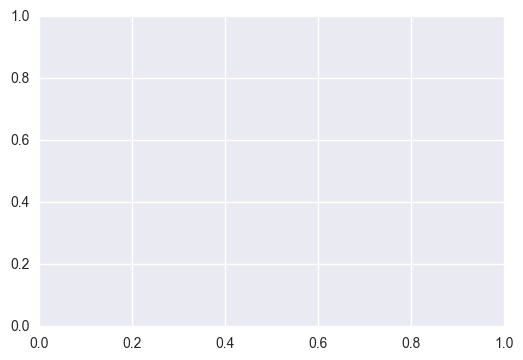

In [261]:
model.plot_learning_curve(logy=True, savename='test')

In [242]:
def extract_mentions(seq):
    """ We extract mentions approximately according to the BIO or BILOU schemes
    with some relaxations.
    
    We start mentions when we see anything but an 'O'. 
    We end them when we see an 'O'.
    """
    mentions = []
    in_mention = False
    mention_start = mention_end = 0
    for i, s in enumerate(seq):
        if not in_mention and s in ['B', 'I', 'L', 'U']:
            mention_start = i
            in_mention = True
        elif in_mention and s == 'O':
            mentions.append((mention_start, i-1))
            in_mention=False
    if in_mention: # we end on a mention
        mentions.append((mention_start, i))
    return mentions
    
def extract_all_mentions(seqs):
    return [extract_mentions(seq) for seq in seqs]

In [243]:
def mention_precision_recall(true_mentions, pred_mentions):
    """ This function returns the counts of true positives, false positives, and false negatives
    which are necessary for calculating precision and recall.
    A mention boundary is considered correct if both ends are correct. 
    """
    true_mentions = set(true_mentions)
    pred_mentions = set(pred_mentions)
    tp = len(true_mentions & pred_mentions)
    fn = len(true_mentions - pred_mentions)
    fp = len(pred_mentions - true_mentions)
    return tp, fp, fn

def mention_boundary_stats(true_ys, pred_ys):
    all_true_mentions = extract_all_mentions(true_ys)
    all_pred_mentions = extract_all_mentions(pred_ys)
    stats = {'tp':0,
             'fp':0,
             'fn':0}
    for true_mentions, pred_mentions in zip(all_true_mentions, all_pred_mentions):
        tp, fp, fn = mention_precision_recall(true_mentions, pred_mentions)
        stats['tp'] += tp
        stats['fp'] += fp
        stats['fn'] += fn
    stats['precision'] = tp / float(tp + fp)
    stats['recall'] = tp / float(tp + fn)
    stats['f1'] = 2*stats['precision']*stats['recall']/(stats['precision']+stats['recall'])
    return stats

In [246]:
f1_stats = mention_boundary_stats(y_test, model.predict(x_test))
print "P:{s[precision]:2.4f}, R: {s[recall]:2.4f}, F1: {s[f1]:2.4f}".format(s=f1_stats)

P:0.3846, R: 0.4762, F1: 0.4255


In [247]:
zip(x_test[0], y_test[0], model.predict(x_test[:1])[0])

[(u'<', 'O', 'O'),
 (u'DOC', 'O', 'O'),
 (u'>', 'O', 'O'),
 (u'<', 'O', 'O'),
 (u'DOCID', 'O', 'O'),
 (u'>', 'O', 'O'),
 (u'CNN_ENG_20030415_173752.0', 'O', 'O'),
 (u'<', 'O', 'O'),
 (u'/DOCID', 'O', 'O'),
 (u'>', 'O', 'O'),
 (u'<', 'O', 'O'),
 (u'DOCTYPE', 'O', 'O'),
 (u'SOURCE="broadcast', 'O', 'O'),
 (u'news', 'O', 'O'),
 (u'"', 'O', 'O'),
 (u'>', 'O', 'O'),
 (u'NEWS', 'O', 'O'),
 (u'STORY', 'O', 'O'),
 (u'<', 'O', 'O'),
 (u'/DOCTYPE', 'O', 'O'),
 (u'>', 'O', 'O'),
 (u'<', 'O', 'O'),
 (u'DATETIME', 'O', 'O'),
 (u'>', 'O', 'O'),
 (u'2003', 'O', 'O'),
 (u'-', 'O', 'O'),
 (u'04', 'O', 'O'),
 (u'-', 'O', 'O'),
 (u'15', 'O', 'O'),
 (u'17:35:05', 'O', 'O'),
 (u'<', 'O', 'O'),
 (u'/DATETIME', 'O', 'O'),
 (u'>', 'O', 'O'),
 (u'<', 'O', 'O'),
 (u'BODY', 'O', 'O'),
 (u'>', 'O', 'O'),
 (u'<', 'O', 'O'),
 (u'TEXT', 'O', 'O'),
 (u'>', 'O', 'O'),
 (u'<', 'O', 'O'),
 (u'TURN', 'O', 'O'),
 (u'>', 'O', 'O'),
 (u'spy', 'U', 'O'),
 (u'to', 'O', 'O'),
 (u'help', 'O', 'O'),
 (u'free', 'O', 'O'),
 (u'pri